In [1]:
import sys
import os

# Voeg het pad toe aan sys.path
module_path = os.path.abspath(r'H:\My Documents\CapstoneAI-FiberProbe-main')  # of een specifiek pad zoals: '/mnt/data'
if module_path not in sys.path:
    sys.path.append(module_path)

In [109]:
### Start user input ###
path_to_data = r'U:\Bubble Column\Data\2411_Xray alcohols\Fiber Probe\241108 - Water center of column' 
path_to_output = r'H:\My Documents\Capstone results'
### End user input ###

# Libary imports
import pandas as pd
import torch
import numpy as np
import time
import pickle
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import importlib
import models
importlib.reload(models)
# Function imports
from advanced_dataloading import process_folder
from advanced_preprocessing import frame_waves, valid_velo_data, save_second_scaler, random_noise, duplicate_and_augment_data, flatten_data_distribution, bin_data, calculate_duplication_factors
from models import load_scalers, load_models, LSTMModel, GRUModel, CNNModel
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [3]:
start_time = time.time()

In [4]:
df = process_folder(path_to_data, path_to_output, files=[20,17,14,11,8,5,2], plot=False, labels=True,)
end_time = time.time()
print((end_time - start_time)/60)

Binlog data extracted
Processing run: 2024-11-08T161448
{'channelCoef1': 0.0, 'channelCoef2': 6.103701895199438e-05, 'acquisitionFrequency': 20833333.333333332, 'flowRate': 240, 'bin_file': '2024-11-08T161448.bin'}
836458000 datapoints extracted
LABELS: 640 bubble labels with VeloOut != -1 extracted.

Missing Labels:
L_idx: L253, ExitIdx: 327054128, VeloOut: 1.92765
L_idx: L384, ExitIdx: 490162316, VeloOut: 2.32511
EXTRACTED: 638 bubbles have VeloOut != -1 out of 3502 total bubbles.
            bubble_idx E_idx L_idx  VeloOut  \
0  0_2024-11-08T161448    E0    -1 -1.00000   
1  1_2024-11-08T161448    E1    -1 -1.00000   
2  2_2024-11-08T161448    E2    L0  1.46359   
3  3_2024-11-08T161448    E3    -1 -1.00000   
4  4_2024-11-08T161448    E4    -1 -1.00000   

                                          VoltageOut  FlowRate     Frequency  
0  [0.5804620385169983, 0.5878475308418274, 0.607...       240  2.083333e+07  
1  [0.6047548055648804, 0.6321604251861572, 0.632...       240  2.08333

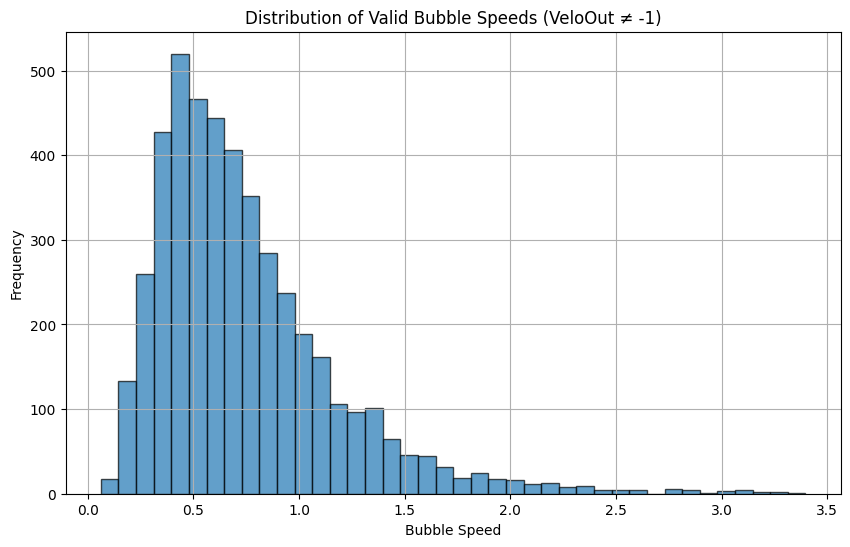

In [230]:
# Filter out invalid speeds
valid_speeds = df[df["VeloOut"] != -1]["VeloOut"]

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.hist(valid_speeds, bins=40, edgecolor='black', alpha=0.7)
plt.title("Distribution of Valid Bubble Speeds (VeloOut ≠ -1)")
plt.xlabel("Bubble Speed")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [328]:
feature_scaler, target_scaler, X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, X_test_scaled, y_test_scaled = save_second_scaler(df)

In [320]:
with open(path_to_output+'/scalers/feature_scaler2-20%3_600.pkl', 'wb') as f:
    pickle.dump(feature_scaler, f)

with open(path_to_output+'/scalers/target_scaler2-20%3_600.pkl', 'wb') as f:
    pickle.dump(target_scaler, f)

2
1.46359


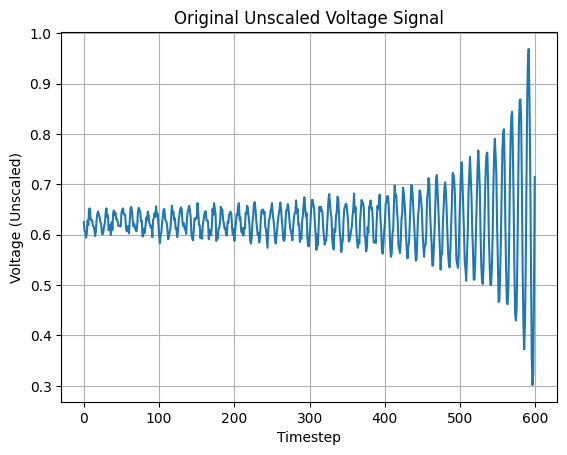

In [326]:
# Select a specific bubble by index (e.g., index 1)
i= 2
print(i)

voltage_signal = df["VoltageOut"].iloc[i]  # This is unscaled
print(df['VeloOut'].iloc[i])
# Create x-axis based on signal length
x = np.arange(len(voltage_signal))

# Plot
plt.plot(x, voltage_signal)
plt.title("Original Unscaled Voltage Signal")
plt.xlabel("Timestep")
plt.ylabel("Voltage (Unscaled)")
plt.grid(True)
plt.show()

In [329]:
chance = 0.3
bins = 30
X_train_scaled, y_train_scaled = random_noise(X_train_scaled, y_train_scaled, chance, random_seed = 0)
hist, bin_indices = bin_data(y_train_scaled, bins)
factors = calculate_duplication_factors(hist)
#X_train_scaled, y_train_scaled = duplicate_and_augment_data(X_train_scaled, y_train_scaled, bin_indices, factors, noise=0.005)
#X_train_scaled, y_train_scaled = flatten_data_distribution(X_train_scaled, y_train_scaled, bins, scaling_factor=0.05, noise=0.005)

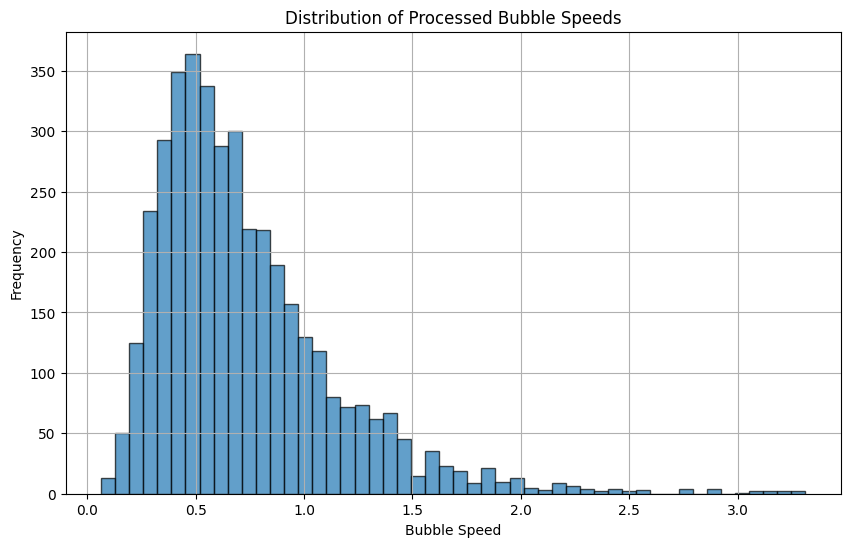

In [330]:
y_train_fig = target_scaler.inverse_transform(y_train_scaled.reshape(-1, 1)).flatten() 
plt.figure(figsize=(10, 6))
plt.hist(y_train_fig, bins=50, edgecolor='black', alpha=0.7)
plt.title("Distribution of Processed Bubble Speeds")
plt.xlabel("Bubble Speed")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [331]:
X_train_scaled.shape

(3983, 600)

In [332]:
X_train_tensor = torch.tensor(X_train_scaled[..., np.newaxis], dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32).unsqueeze(1)
X_val_tensor = torch.tensor(X_val_scaled[..., np.newaxis], dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_scaled, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_scaled[..., np.newaxis], dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32).unsqueeze(1)
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_val_tensor = X_val_tensor.to(device)
y_val_tensor = y_val_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

Epoch 1/7500 - Train Loss: 0.9575 - Val Loss: 1.0844
Epoch 100/7500 - Train Loss: 0.0985 - Val Loss: 0.1059
Epoch 200/7500 - Train Loss: 0.0461 - Val Loss: 0.0488
Epoch 300/7500 - Train Loss: 0.0360 - Val Loss: 0.0421
Epoch 400/7500 - Train Loss: 0.0171 - Val Loss: 0.0321
Epoch 500/7500 - Train Loss: 0.0198 - Val Loss: 0.0171
Epoch 600/7500 - Train Loss: 0.0099 - Val Loss: 0.0137
Epoch 700/7500 - Train Loss: 0.0053 - Val Loss: 0.0145
Epoch 800/7500 - Train Loss: 0.0043 - Val Loss: 0.0141
Epoch 900/7500 - Train Loss: 0.0037 - Val Loss: 0.0138
Epoch 1000/7500 - Train Loss: 0.0035 - Val Loss: 0.0132
Epoch 1100/7500 - Train Loss: 0.0032 - Val Loss: 0.0128
Epoch 1200/7500 - Train Loss: 0.0028 - Val Loss: 0.0125
Epoch 1300/7500 - Train Loss: 0.0026 - Val Loss: 0.0125
Epoch 1400/7500 - Train Loss: 0.0024 - Val Loss: 0.0126
Epoch 1500/7500 - Train Loss: 0.0023 - Val Loss: 0.0127
Epoch 1600/7500 - Train Loss: 0.0022 - Val Loss: 0.0126
Epoch 1700/7500 - Train Loss: 0.0021 - Val Loss: 0.0125
Epoc

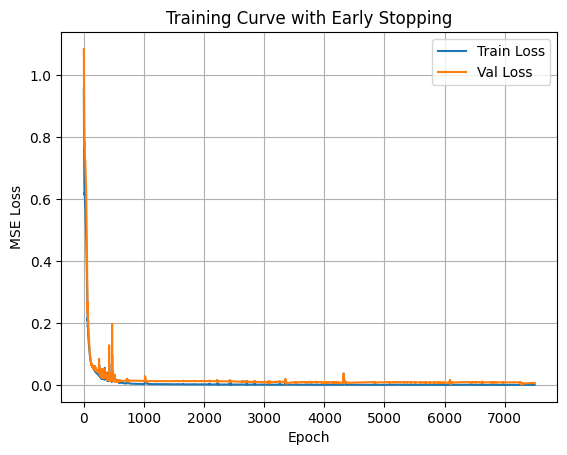

In [335]:
# Model setup
gru1_model = GRUModel(input_size=1, hidden_size=20, num_layers=2)
gru1_model.to(device)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(gru1_model.parameters(), lr=0.004)

# Early stopping parameters
patience = 3000
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_state = None

# Training loop
epochs = 7500
train_losses, val_losses = [], []

for epoch in range(epochs):
    gru1_model.train()
    optimizer.zero_grad()
    y_pred_train = gru1_model(X_train_tensor)
    loss = criterion(y_pred_train, y_train_tensor)
    loss.backward()
    optimizer.step()

    gru1_model.eval()
    with torch.no_grad():
        y_pred_val = gru1_model(X_val_tensor)
        val_loss = criterion(y_pred_val, y_val_tensor)

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    # Early stopping logic
    if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        best_model_state = {k: v.clone() for k, v in gru1_model.state_dict().items()}
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    if (epoch+1) % 100 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {loss.item():.4f} - Val Loss: {val_loss.item():.4f}")

# Restore best model
if best_model_state is not None:
    gru1_model.load_state_dict(best_model_state)

# Plot loss curves
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Curve with Early Stopping")
plt.legend()
plt.grid(True)
plt.show()

In [336]:
# Predict on validation set
gru1_model.eval()
with torch.no_grad():
    y_pred_scaled = gru1_model(X_val_tensor).detach().cpu().numpy().flatten()

# Inverse-transform
y_pred_gru1 = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_true = target_scaler.inverse_transform(y_val_tensor.cpu().numpy().reshape(-1, 1)).flatten()

# Metrics
rmse = mean_squared_error(y_true, y_pred_gru1)
mae = mean_absolute_error(y_true, y_pred_gru1)
r2 = r2_score(y_true, y_pred_gru1)

print(f"RMSE: {rmse:.4f} cm/s")
print(f"MAE: {mae:.4f} cm/s")
print(f"R² Score: {r2:.4f}")

RMSE: 0.0004 cm/s
MAE: 0.0102 cm/s
R² Score: 0.9982


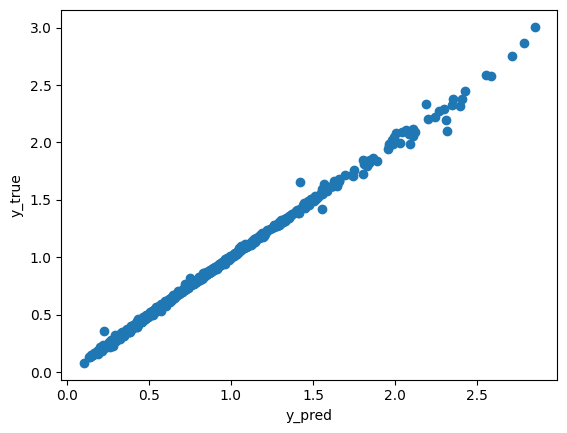

In [337]:
plt.figure()
plt.scatter(y_pred_gru1,y_true)
plt.xlabel('y_pred')
plt.ylabel('y_true')
plt.show()

Epoch 1/50000 - Train Loss: 1.0858 - Val Loss: 1.2401
Epoch 250/50000 - Train Loss: 0.0215 - Val Loss: 0.0136
Epoch 500/50000 - Train Loss: 0.0128 - Val Loss: 0.0083
Epoch 750/50000 - Train Loss: 0.0096 - Val Loss: 0.0095
Epoch 1000/50000 - Train Loss: 0.0073 - Val Loss: 0.0093
Epoch 1250/50000 - Train Loss: 0.0128 - Val Loss: 0.0169
Epoch 1500/50000 - Train Loss: 0.0043 - Val Loss: 0.0094
Epoch 1750/50000 - Train Loss: 0.0647 - Val Loss: 0.0876
Epoch 2000/50000 - Train Loss: 0.0144 - Val Loss: 0.0215
Epoch 2250/50000 - Train Loss: 0.0092 - Val Loss: 0.0165
Epoch 2500/50000 - Train Loss: 0.0075 - Val Loss: 0.0161
Epoch 2750/50000 - Train Loss: 0.0063 - Val Loss: 0.0193
Epoch 3000/50000 - Train Loss: 0.0050 - Val Loss: 0.0188
Epoch 3250/50000 - Train Loss: 0.0692 - Val Loss: 0.0646
Epoch 3500/50000 - Train Loss: 0.0068 - Val Loss: 0.0115
Epoch 3750/50000 - Train Loss: 0.0042 - Val Loss: 0.0130
Epoch 4000/50000 - Train Loss: 0.0034 - Val Loss: 0.0151
Epoch 4250/50000 - Train Loss: 0.0034

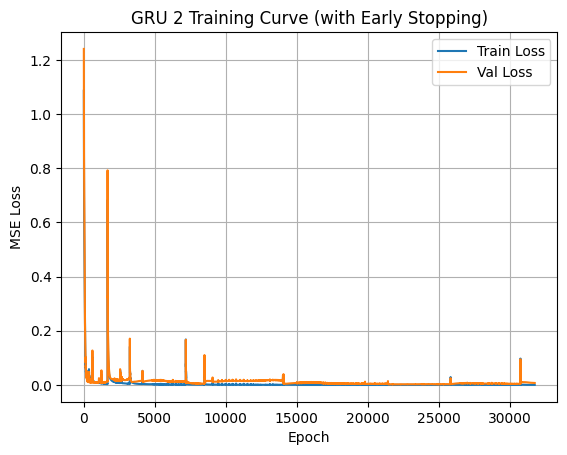

In [349]:
gru2_model = GRUModel(input_size=1, hidden_size=10, num_layers=3)
gru2_model.to(device)

# Optimizer and loss
optimizer = torch.optim.Adam(gru2_model.parameters(), lr=0.005)
criterion = torch.nn.MSELoss()

# Early stopping setup
patience = 10000
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_state = None

# Training
epochs = 50000
train_losses, val_losses = [], []

for epoch in range(epochs):
    gru2_model.train()
    optimizer.zero_grad()
    pred_train = gru2_model(X_train_tensor)
    loss = criterion(pred_train, y_train_tensor)
    loss.backward()
    optimizer.step()

    gru2_model.eval()
    with torch.no_grad():
        pred_val = gru2_model(X_val_tensor)
        val_loss = criterion(pred_val, y_val_tensor)

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    # Early stopping logic
    if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        best_model_state = {k: v.clone() for k, v in gru2_model.state_dict().items()}
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    if (epoch+1) % 250 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {loss.item():.4f} - Val Loss: {val_loss.item():.4f}")

# Restore best model weights
if best_model_state is not None:
    gru2_model.load_state_dict(best_model_state)

# Plot
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("GRU 2 Training Curve (with Early Stopping)")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.legend()
plt.show()

In [350]:
# Predict on validation set
gru2_model.eval()
with torch.no_grad():
    y_pred_scaled = gru2_model(X_val_tensor).detach().cpu().numpy().flatten()

# Inverse-transform
y_pred_gru2 = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_true = target_scaler.inverse_transform(y_val_tensor.cpu().numpy().reshape(-1, 1)).flatten()

# Metrics
rmse = mean_squared_error(y_true, y_pred_gru2)
mae = mean_absolute_error(y_true, y_pred_gru2)
r2 = r2_score(y_true, y_pred_gru2)

print(f"RMSE: {rmse:.4f} cm/s")
print(f"MAE: {mae:.4f} cm/s")
print(f"R² Score: {r2:.4f}")

RMSE: 0.0004 cm/s
MAE: 0.0072 cm/s
R² Score: 0.9981


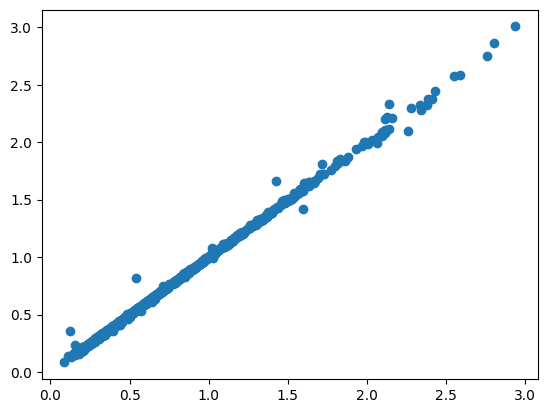

In [351]:
plt.figure()
plt.scatter(y_pred_gru2,y_true)
plt.show()

Epoch 1/75000 - Train Loss: 1.0096 - Val Loss: 1.1665
Epoch 500/75000 - Train Loss: 0.0197 - Val Loss: 0.0303
Epoch 1000/75000 - Train Loss: 0.0132 - Val Loss: 0.0298
Epoch 1500/75000 - Train Loss: 0.0060 - Val Loss: 0.0237
Epoch 2000/75000 - Train Loss: 0.0038 - Val Loss: 0.0234
Epoch 2500/75000 - Train Loss: 0.0028 - Val Loss: 0.0241
Epoch 3000/75000 - Train Loss: 0.0025 - Val Loss: 0.0248
Epoch 3500/75000 - Train Loss: 0.0029 - Val Loss: 0.0263
Epoch 4000/75000 - Train Loss: 0.0022 - Val Loss: 0.0255
Epoch 4500/75000 - Train Loss: 0.0028 - Val Loss: 0.0313
Epoch 5000/75000 - Train Loss: 0.0021 - Val Loss: 0.0251
Epoch 5500/75000 - Train Loss: 0.0019 - Val Loss: 0.0211
Epoch 6000/75000 - Train Loss: 0.0020 - Val Loss: 0.0185
Epoch 6500/75000 - Train Loss: 0.0021 - Val Loss: 0.0094
Epoch 7000/75000 - Train Loss: 0.0018 - Val Loss: 0.0096
Epoch 7500/75000 - Train Loss: 0.0016 - Val Loss: 0.0133
Epoch 8000/75000 - Train Loss: 0.0015 - Val Loss: 0.0145
Epoch 8500/75000 - Train Loss: 0.00

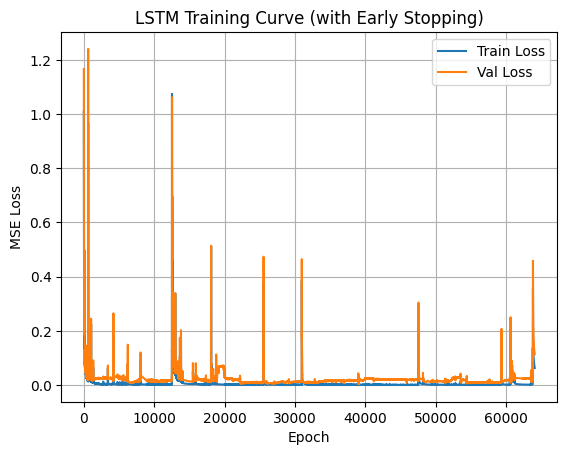

In [356]:
lstm_model = LSTMModel(input_size=1, hidden_size=18, num_layers=2)
lstm_model.to(device)

# Loss and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.008)

# Early stopping setup
patience = 25000
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_state = None

# Training loop
epochs = 75000
train_losses, val_losses = [], []

for epoch in range(epochs):
    lstm_model.train()
    optimizer.zero_grad()
    y_pred_train = lstm_model(X_train_tensor)
    loss = criterion(y_pred_train, y_train_tensor)
    loss.backward()
    optimizer.step()

    lstm_model.eval()
    with torch.no_grad():
        y_pred_val = lstm_model(X_val_tensor)
        val_loss = criterion(y_pred_val, y_val_tensor)

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    # Early stopping logic
    if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        best_model_state = {k: v.clone() for k, v in lstm_model.state_dict().items()}
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    if (epoch+1) % 500 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {loss.item():.4f} - Val Loss: {val_loss.item():.4f}")

# Restore best model weights
lstm_model.load_state_dict(best_model_state)

# Plot loss curves
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("LSTM Training Curve (with Early Stopping)")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.legend()
plt.show()


In [357]:
# Predict on validation set
lstm_model.eval()
with torch.no_grad():
    y_pred_scaled = lstm_model(X_val_tensor).detach().cpu().numpy().flatten()

# Inverse-transform
y_pred_lstm = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_true = target_scaler.inverse_transform(y_val_tensor.cpu().numpy().reshape(-1, 1)).flatten()

# Metrics
rmse = mean_squared_error(y_true, y_pred_lstm)
mae = mean_absolute_error(y_true, y_pred_lstm)
r2 = r2_score(y_true, y_pred_lstm)

print(f"RMSE: {rmse:.4f} cm/s")
print(f"MAE: {mae:.4f} cm/s")
print(f"R² Score: {r2:.4f}")

RMSE: 0.0007 cm/s
MAE: 0.0128 cm/s
R² Score: 0.9968


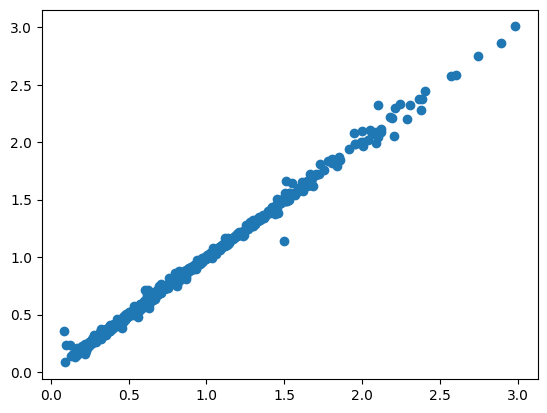

In [358]:
plt.figure()
plt.scatter(y_pred_lstm,y_true)
plt.show()

Epoch 1/15000 - Train Loss: 0.9790 - Val Loss: 1.1631
Epoch 250/15000 - Train Loss: 0.0026 - Val Loss: 0.0060
Epoch 500/15000 - Train Loss: 0.0012 - Val Loss: 0.0037
Epoch 750/15000 - Train Loss: 0.0005 - Val Loss: 0.0030
Epoch 1000/15000 - Train Loss: 0.0005 - Val Loss: 0.0029
Epoch 1250/15000 - Train Loss: 0.0004 - Val Loss: 0.0025
Epoch 1500/15000 - Train Loss: 0.0018 - Val Loss: 0.0023
Epoch 1750/15000 - Train Loss: 0.0022 - Val Loss: 0.0045
Epoch 2000/15000 - Train Loss: 0.0003 - Val Loss: 0.0025
Epoch 2250/15000 - Train Loss: 0.0004 - Val Loss: 0.0028
Epoch 2500/15000 - Train Loss: 0.0005 - Val Loss: 0.0043
Epoch 2750/15000 - Train Loss: 0.0003 - Val Loss: 0.0042
Epoch 3000/15000 - Train Loss: 0.0002 - Val Loss: 0.0043
Epoch 3250/15000 - Train Loss: 0.0002 - Val Loss: 0.0040
Epoch 3500/15000 - Train Loss: 0.0002 - Val Loss: 0.0038
Epoch 3750/15000 - Train Loss: 0.0002 - Val Loss: 0.0037
Epoch 4000/15000 - Train Loss: 0.0001 - Val Loss: 0.0039
Epoch 4250/15000 - Train Loss: 0.0004

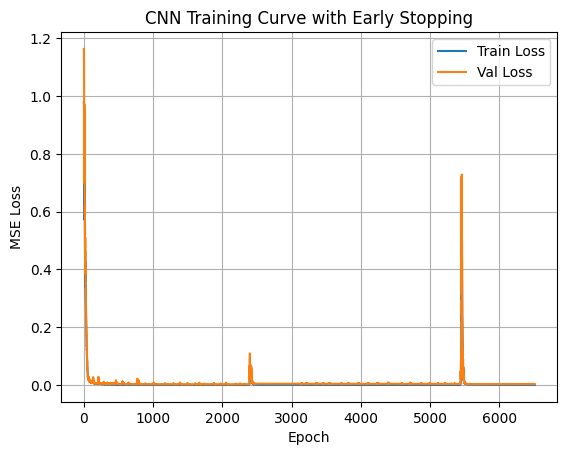

In [343]:
# Model setup
cnn_model = CNNModel(input_channels=1, hidden_units=32, kernel_size=9, num_layers=7, input_length=600, output_size=1) 
cnn_model.to(device)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.002)

# Early stopping parameters
patience = 5000
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_state = None

# Training loop
epochs = 15000
train_losses, val_losses = [], []

for epoch in range(epochs):
    # Training
    cnn_model.train()
    optimizer.zero_grad()
    y_pred_train = cnn_model(X_train_tensor)
    loss = criterion(y_pred_train, y_train_tensor)
    loss.backward()
    optimizer.step()

    # Validation
    cnn_model.eval()
    with torch.no_grad():
        y_pred_val = cnn_model(X_val_tensor)
        val_loss = criterion(y_pred_val, y_val_tensor)

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    # Early stopping logic
    if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        best_model_state = {k: v.clone() for k, v in cnn_model.state_dict().items()}
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    # Progress output
    if (epoch+1) % 250 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {loss.item():.4f} - Val Loss: {val_loss.item():.4f}")

# Restore best model
if best_model_state is not None:
    cnn_model.load_state_dict(best_model_state)

# Save the trained CNN model
torch.save(cnn_model.state_dict(), "advanced_model_files/CNN_model.h5")

# Plot loss curves
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("CNN Training Curve with Early Stopping")
plt.legend()
plt.grid(True)
plt.show()


In [348]:
# torch.save(cnn_model.state_dict(), path_to_output+"/models/cnn28-5_2-20%3_ic1_hu32_ks9_nl7_lr0.002_ep6510es_r20.9982")

In [359]:
# Predict on validation set
cnn_model.eval()
with torch.no_grad():
    y_pred_scaled = cnn_model(X_val_tensor).detach().cpu().numpy().flatten()

# Inverse-transform
y_pred_cnn = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_true = target_scaler.inverse_transform(y_val_tensor.cpu().numpy().reshape(-1, 1)).flatten()

# Metrics
rmse = mean_squared_error(y_true, y_pred_cnn)
mae = mean_absolute_error(y_true, y_pred_cnn)
r2 = r2_score(y_true, y_pred_cnn)

print(f"RMSE: {rmse:.4f} cm/s")
print(f"MAE: {mae:.4f} cm/s")
print(f"R² Score: {r2:.4f}")

RMSE: 0.0004 cm/s
MAE: 0.0092 cm/s
R² Score: 0.9982


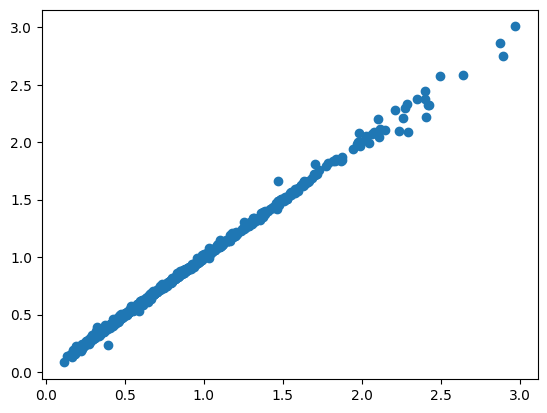

In [360]:
plt.figure()
plt.scatter(y_pred_cnn,y_true)
plt.show()

In [352]:

# torch.save(gru1_model.state_dict(), path_to_output+"/models/gru28-5_2-20%3_is1_ns20_nl2_lr0.004_ep7500_r20.9982-")
# torch.save(gru2_model.state_dict(), path_to_output+"/models/gru28-5_2-20%3_is1_ns10_nl3_lr0.005_ep31776es_r20.9981")
# torch.save(lstm_model.state_dict(), path_to_output+"/models/lstm26-5_2-20%3_is1_ns18_nl2_lr0.001_ep150000_r20.998-")


In [28]:
end_time = time.time()
print((end_time - start_time)/60)

86.9571437438329
